# README    
1.数据输入-->添加序列,kmer序列-->切分测试/验证集-->测试集产生promoter/enhancer embeding 矩阵-->网络输入


# Read Data

In [1]:
datafile  =   '/home/yinqijin/WorkSpace/2.RNA_Structure_Profile/Orig_data/targetfinder/GM12878/output-epw/pairs.csv'
import csv
import numpy as np

In [2]:
#读入CSV表头
with open(datafile) as csvfile:
    spamreader = csv.reader(csvfile)
    for  row in spamreader:
        csvkeys = row
        break
print csvkeys

['bin', 'enhancer_chrom', 'enhancer_distance_to_promoter', 'enhancer_end', 'enhancer_name', 'enhancer_start', 'label', 'promoter_chrom', 'promoter_end', 'promoter_name', 'promoter_start', 'window_end', 'window_start', 'window_chrom', 'window_name', 'interactions_in_window', 'active_promoters_in_window']


In [3]:
#分别读入正负样本[完全未处理]
poscsv = {}
negcsv = {}
with open(datafile) as csvfile:
    reader = csv.DictReader(csvfile)
    for line in reader:
        if line['bin']  not in poscsv.keys():
            poscsv[line['bin']] =[]
        if line ['bin']  not in negcsv.keys():
            negcsv[line['bin']] =[]

        record=[ line['enhancer_chrom']+' '+
                line[ 'enhancer_start']+' '+
                line['enhancer_end']+' '+
                line['promoter_chrom']+' '+
                line['promoter_start']+' '+
                line['promoter_end']+' '+
                line['enhancer_name']+'-'+line['promoter_name']
                  ]
        if line['label']==str(1):
            poscsv[line['bin']].append(record)
        else:
            negcsv[line['bin']].append(record)

    for key in poscsv.keys():
        length = len(poscsv[key])
        index = range(len(negcsv[key]))
        np.random.shuffle(index)
        negcsv[key] = np.array(negcsv[key])
        negcsv[key] = negcsv[key][index[:length]]
        #print len(negcsv[key])

In [4]:
#分别读入正负样本[处理:样本均衡]
posdata =[]
negdata = []
for key in poscsv.keys():
    posdata = np.append(posdata,poscsv[key])
    negdata = np.append(negdata,negcsv[key])
assert  len(posdata) == len(negdata)
print  len(posdata),len(negdata)

2113 2113


# 数据序号-->数据序列

In [5]:
from pyfasta import Fasta
genome = Fasta('/home/yinqijin/WorkSpace/DataHub/genome.fa')

#获得ｋｍｅｒ的函数
embed_dict =[]
def seq_to_embed_seq(seq):
    kmer=6
    embed_seq = []
    if len (seq)< kmer:
        return embed_seq
    for i in range(kmer,len(seq)):
        word  = seq[(i-kmer):i] 
        #if  word not in embed_dict.keys():
        #    embed_dict[ word  ] =str( len(embed_dict.keys()) ) #给标号
        #embed_seq.append(  str( embed_dict[ word  ]  )  )
        embed_seq.append(  word )
        if word not in embed_dict:
            embed_dict.append(word)
    return embed_seq

In [6]:
sentence_len = 806
half_len = sentence_len/2

PESeq=dict()
PESeq['index']=[]
PESeq['Pro-Seq']=[]
PESeq['Pro-ESeq']=[]
PESeq['Ehr-Seq']=[]
PESeq['Ehr-ESeq']=[]
PESeq['label'] =[]

#正样本
for index in range(len(posdata)):
    line = posdata[index]
    #print line
    line = line.split()
    ehr_seq = genome[line[0]][int(line[1]): int(line[2]) ].upper()
    pro_seq = genome [line[3]][int(line[4]) :int(line[5])].upper()
    index = line[6]
    
    if len(pro_seq)<6:
        print line
        continue
    if len(ehr_seq)<6:
        print line
        continue
    
    middle = ( int(line[1])+int(line[2]))//2
    ehr_seq = genome[line[0]][  (middle-half_len): (middle+half_len)   ].upper()
    pro_seq = genome [line[3]][  (middle-half_len): (middle+half_len)  ].upper()
    
    PESeq['index'].append(index )
    PESeq['Pro-Seq'].append(pro_seq)
    #print len(pro_seq)-len(seq_to_embed_seq(pro_seq))
    #print seq_to_embed_seq(pro_seq)
    
    PESeq['Pro-ESeq'].append( seq_to_embed_seq(pro_seq))
    PESeq['Ehr-Seq'].append(ehr_seq)
    #print seq_to_embed_seq(ehr_seq)
    #break
    PESeq['Ehr-ESeq'].append(seq_to_embed_seq(ehr_seq))
    PESeq['label'].append(1)
print 'pos over'
print len(PESeq['label'])  

#负样本
  
for  index in range(len(negdata)):
    #break
    line = negdata[index]
    line = line.split()
    ehr_seq = genome[line[0]][int(line[1]): int(line[2]) ].upper()
    pro_seq = genome [line[3]][int(line[4]) :int(line[5])].upper()
    index = line[6]
    
    #负样本比较多 可以严格限制 不可以 设置为1000 只剩168
    if len(pro_seq)<6:
        print line
        continue
    if len(ehr_seq)<6:
        print line
        continue
     
    middle = ( int(line[1])+int(line[2]))//2
    ehr_seq = genome[line[0]][  (middle-half_len): (middle+half_len)   ].upper()
    pro_seq = genome [line[3]][  (middle-half_len): (middle+half_len)  ].upper()
    
    PESeq['index'].append(index )
    PESeq['Pro-Seq'].append(pro_seq)
    PESeq['Pro-ESeq'].append( seq_to_embed_seq(pro_seq))
    PESeq['Ehr-Seq'].append(ehr_seq)
    PESeq['Ehr-ESeq'].append(seq_to_embed_seq(ehr_seq))
    PESeq['label'].append(0)
print 'neg over'

print len(PESeq['label'])

['chr17', '41080595', '41080600', 'chr17', '40728821', '40732200', 'GM12878|chr17:41080595-41080600-GM12878|chr17:40728821-40732200']
['chr3', '144015595', '144015600', 'chr3', '143689613', '143692895', 'GM12878|chr3:144015595-144015600-GM12878|chr3:143689613-143692895']
['chr6', '27857195', '27857200', 'chr6', '27803860', '27807953', 'GM12878|chr6:27857195-27857200-GM12878|chr6:27803860-27807953']
pos over
2110
['chr19', '45677600', '45677605', 'chr19', '44455037', '44455747', 'GM12878|chr19:45677600-45677605-GM12878|chr19:44455037-44455747']
['chr14', '23285600', '23285605', 'chr14', '24898401', '24901080', 'GM12878|chr14:23285600-23285605-GM12878|chr14:24898401-24901080']
['chr6', '2856795', '2856800', 'chr6', '3156975', '3158233', 'GM12878|chr6:2856795-2856800-GM12878|chr6:3156975-3158233']
['chr17', '41080595', '41080600', 'chr17', '41276342', '41278462', 'GM12878|chr17:41080595-41080600-GM12878|chr17:41276342-41278462']
['chr19', '17576795', '17576800', 'chr19', '17621165', '1762

In [7]:
print '-'*50
for item in PESeq.keys():
    print item, np.shape(PESeq[item])
print 'pos data' , sum(int( 1 ) if item ==1 else int(0) for item in PESeq['label'])
print 'neg data',sum(int( 1) if item ==0 else int(0) for item in PESeq['label'])



--------------------------------------------------
index (4217,)
Ehr-Seq (4217,)
label (4217,)
Ehr-ESeq (4217, 800)
Pro-Seq (4217,)
Pro-ESeq (4217, 800)
pos data 2110
neg data 2107


# 拆分训练集和测试集

# Word2vec Embeding

In [8]:
from gensim.models import Word2Vec,word2vec
import numpy as np
np.random.seed(1234)

In [9]:
# embeding 的训练只用训练集的数据
from numpy.random import shuffle
dataset_length = np.shape( PESeq['Pro-ESeq'])[0]
SPLIT_point = int(0.85*dataset_length)
seq_index = range(dataset_length)
shuffle(seq_index)
train_index = seq_index[:SPLIT_point]
valid_index = seq_index[SPLIT_point:]

Pro_Sentense = np.array(PESeq['Pro-ESeq'])[train_index]
Ehr_Sentense = np.array(PESeq['Ehr-ESeq'])[train_index]

In [10]:

with open('./Gen_data/14_Pro_sentense.txt','w') as f:
    for row in range(np.shape( Pro_Sentense)[0]):
        Sentense = Pro_Sentense[row]
        f.write( ' '.join(Sentense)+'\n')
        
with open('./Gen_data/14_Ehr_sentense.txt','w') as f:
    for row in range(np.shape( Ehr_Sentense)[0]):
        Sentense = Ehr_Sentense[row]
        f.write( ' '.join(Sentense)+'\n')

In [11]:
Pro_sentences = word2vec.LineSentence('./Gen_data/14_Pro_sentense.txt')
model = Word2Vec(Pro_sentences, size=100, window=5, min_count=5, workers=4)
print(model)
#print(model.wv['AAAAAA'])
pro_word_vectors = model.wv

Word2Vec(vocab=4096, size=100, alpha=0.025)


In [14]:
Ehr_sentences = word2vec.LineSentence('./Gen_data/14_Ehr_sentense.txt')
model = Word2Vec(Pro_sentences, size=100, window=5, min_count=5, workers=4)
print(model)
#print(model.wv['AAAAAA'])
ehr_word_vectors = model.wv

Word2Vec(vocab=4096, size=100, alpha=0.025)


In [15]:
print  len(ehr_word_vectors.index2word)
for item in ehr_word_vectors.index2word[:4]:
    print item
print  np.shape(ehr_word_vectors['AAAAAA'])
ehr_word_vectors.word_vec

ehr_word_vectors.index2word[965]

ehr_word_vectors.index2word.index('TAACTA')


4096
TTTTTT
AAAAAA
ATTTTT
AAAAAT
(100,)


2513

In [16]:
if 'TAACTA'  in ehr_word_vectors.index2word:
    print 'in'
else:
    print 'no'

in


In [17]:
embed_dict_len = len(embed_dict)

In [18]:
pro_embedding_matrix = np.random.random((embed_dict_len,100))  #4096个字,每个字100维
for item in range(embed_dict_len):
    word  = embed_dict[item] 
    if word in pro_word_vectors.index2word :   
        pro_embedding_matrix[item]= pro_word_vectors[word]

In [19]:
ehr_embedding_matrix = np.zeros((4096,100))  #4096个字,每个字100维
for item in range(4096):
    ehr_embedding_matrix[item]= ehr_word_vectors[word]

In [20]:
print np.shape(pro_embedding_matrix)
pro_embedding_matrix[2000]

(4096, 100)


array([  2.77023703e-01,   1.30715024e+00,  -1.05627215e+00,
        -7.14119256e-01,   7.42347598e-01,   1.29613113e+00,
        -8.30136120e-01,   9.37287867e-01,  -3.01328039e+00,
        -4.43652540e-01,  -3.22756678e-01,  -9.62789178e-01,
        -1.60254383e+00,   1.57136619e+00,  -2.18090439e+00,
         2.48331904e+00,   3.82074654e-01,   1.97296083e+00,
        -4.27986085e-01,   1.88951135e-01,  -6.32472411e-02,
         3.49259049e-01,  -2.63271546e+00,   1.04935847e-01,
        -1.61331385e-01,   6.14249483e-02,   1.39444220e+00,
        -4.56674218e-01,   1.24256778e+00,   3.83091122e-01,
         4.77632791e-01,  -1.88991761e+00,  -1.49155331e+00,
        -6.65175676e-01,   3.26359129e+00,   3.69734555e-01,
         8.13600302e-01,   1.28095910e-01,  -1.55147660e+00,
        -1.39809108e+00,   1.75127995e+00,   1.07478642e+00,
         7.49775290e-01,   7.24820197e-01,   4.28902835e-01,
        -1.76280308e+00,   1.35799837e+00,  -1.10192430e+00,
         7.14373469e-01,

In [2]:
import pickle as pkl
import numpy as np


output = open('./Gen_data/14_'+'GM12878'+'_embedding_matrix.pkl','w')
pkl.dump(pro_embedding_matrix,output)
pkl.dump(ehr_embedding_matrix,output)
output.close()

In [3]:
input_file = open('./Gen_data/14_'+'GM12878'+'_embedding_matrix.pkl','r')
pro_embedding_matrix = pkl.load(input_file)
ehr_embedding_matrix = pkl.load(input_file)
input_file.close()

# 准备输入

In [24]:
pro_input=[]
for item in range(len(PESeq['label'])):
    pro_origin_sentense = PESeq['Pro-ESeq'][item]
    pro_index_sentense = []
    for word in  pro_origin_sentense:
        
        pro_index_sentense.append( pro_word_vectors.index2word.index( word))
    pro_input.append(pro_index_sentense)
    #print pro_index_sentense
print 'pro_fin!'

ehr_input=[]
func = lambda word: ehr_word_vectors.index2word.index(word)
for item in range(len(PESeq['label'])):
    ehr_origin_sentense = PESeq['Ehr-ESeq'][item]
    ehr_index_sentense = []
    for word in  ehr_origin_sentense:
        ehr_index_sentense.append( ehr_word_vectors.index2word.index( word))
    ehr_input.append(pro_index_sentense)
    #print pro_index_sentense
print 'ehr_fin!'

pro_fin!
ehr_fin!


In [25]:
pro_input = np.array(pro_input)
ehr_input = np.array(ehr_input)

In [26]:
Y_org = PESeq['label']

import pickle as pkl
output = open('./Gen_data/14_GM12878_Network_input.pkl','w')
pkl.dump(pro_input,output)
pkl.dump(ehr_input,output)
pkl.dump(PESeq['label'],output)
pkl.dump(train_index,output)
pkl.dump(valid_index,output)
output.close()


In [4]:
import pickle as pkl
input_file = open('./Gen_data/14_GM12878_Network_input.pkl','r')
pro_input = pkl.load(input_file)
ehr_input = pkl.load(input_file)
Y_org=pkl.load(input_file)
train_index = pkl.load(input_file)
valid_index = pkl.load(input_file)
input_file.close()

# 切分训练集

In [5]:
from keras.utils.np_utils import to_categorical

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)


In [6]:
Y = to_categorical(Y_org)

In [7]:
x_train ,y_train =pro_input[train_index], Y[train_index]
x_valid ,y_valid = pro_input[valid_index], Y[valid_index]

x_train_ehr ,x_valid_ehr =ehr_input[train_index], ehr_input[valid_index]

In [8]:
print np.shape(x_train[0]),y_train[0]

(800,) [ 1.  0.]


# Network

In [9]:
from keras.layers import Embedding,InputLayer
from keras.layers import Dense,Input,Activation
from keras.layers import Embedding, LSTM, Bidirectional,GRU,InputLayer
from keras.models import Model,Sequential
from  keras.regularizers import ActivityRegularizer
from keras.layers.core import Dropout,Flatten,Merge

In [10]:
from keras import backend as K
from keras import optimizers as opt

In [15]:
EMBEDDING_DIM =100
MAX_SEQUENCE_LENGTH = 800  
nb_words =4096   #字典的len(keys())

#  Net1: LSTM

In [ ]:
embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[pro_embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
ehr_embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[pro_embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

left = Sequential()
left.add( InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,),input_dtype='int32'))
left.add(embedding_layer)

right = Sequential()
right.add( InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,),input_dtype='int32'))
right.add(ehr_embedding_layer)

model = Sequential()
model.add(Merge([left, right], mode='concat'))
model.add(Bidirectional(LSTM(2,return_sequences=True)))
model.add(Dense(64))
model.add(Dense(16))
model.add(Dense(2, activation='softmax',activity_regularizer= ActivityRegularizer(l2=0.005)))
model.compile(loss='mse', optimizer='rmsprop',metrics=['acc'])
model.summary()

In [ ]:
model.fit([x_train, x_train_ehr], y_train, batch_size=128, nb_epoch=20, validation_data=([x_valid, x_valid_ehr], y_valid))

# Net2 : Att-BLSTM

In [16]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializations
# Attention GRU network
class AttLayer(Layer):
    def __init__(self, **kwargs):
        self.init = initializations.get('normal')
        #self.input_spec = [InputSpec(ndim=3)]
        super(AttLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape)==3
        #self.W = self.init((input_shape[-1],1))
        self.W = self.init((input_shape[-1],))
        #self.input_spec = [InputSpec(shape=input_shape)]
        self.trainable_weights = [self.W]
        super(AttLayer, self).build(input_shape)  # be sure you call this somewhere!

    def call(self, x, mask=None):


        M = K.tanh(x)
        alpha = K.dot(M,self.W)#.dimshuffle(0,2,1)

        ai = K.exp(alpha)
        weights = ai/K.sum(ai, axis=1).dimshuffle(0,'x')
        weighted_input = x*weights.dimshuffle(0,1,'x')
        return K.tanh(weighted_input.sum(axis=1))
        '''
        eij = K.tanh(K.dot(x, self.W))

        ai = K.exp(eij)
        weights = ai/K.sum(ai, axis=1).dimshuffle(0,'x')

        weighted_input = x*weights.dimshuffle(0,1,'x')
        return weighted_input.sum(axis=1)
        '''
    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[-1])

In [17]:
embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[pro_embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
ehr_embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[pro_embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [18]:
left = Sequential()
left.add( InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,),input_dtype='int32'))
left.add(embedding_layer)

right = Sequential()
right.add( InputLayer(input_shape=(MAX_SEQUENCE_LENGTH,),input_dtype='int32'))
right.add(ehr_embedding_layer)

model = Sequential()
model.add(Merge([left, right], mode='concat'))
model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(AttLayer())
model.add(Dense(2, activation='softmax',activity_regularizer= ActivityRegularizer(l2=0.005)))
rmsprop = opt.rmsprop(lr=0.0001)
model.compile(loss='mse', optimizer=rmsprop,metrics=['acc'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 800)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 800, 100)      409600                                       
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 800)           0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 800, 100)      409600                                       
___________________________________________________________________________________________

In [19]:
from sklearn import metrics
cell_type = 'GM12878'
with open('./Gen_data/14_'+cell_type+'_newwork_result.txt','w') as f:
    f.write( ','.join(  ['acc','auc','f1_score']))
    for iter_index in range(40):
        model.fit([x_train, x_train_ehr], y_train, batch_size=128, nb_epoch=10, validation_data=([x_valid, x_valid_ehr], y_valid))
        pro = model.predict_on_batch([x_valid,x_valid_ehr])
        y_pred = [ 1 if item1>item0 else 0 for item0,item1 in pro]
        acc = metrics.accuracy_score(y_valid[:,1],y_pred)
        auc = metrics.roc_auc_score(y_valid[:,1],pro[:,1])
        f1_score = metrics.f1_score(y_valid[:,1],y_pred)
        f.write('{:2f},{:2f},{:2f}'.format(acc,auc,f1_score))
        print '{:2f},{:2f},{:2f}'.format(acc,auc,f1_score)
        if  iter_index%19==0 :
            model.save_weights('./Gen_data/14_Att-BLSTM_model_iter{:03d}.h5'.format (iter_index*10))
    model.save_weights('./Gen_data/14_Att-BLSTM_model_iter{:s}.h5'.format ('fin'))

Train on 3584 samples, validate on 633 samples
Epoch 1/10
3584/3584 [==============================] - 58s - loss: 0.5706 - acc: 0.4897 - val_loss: 0.5673 - val_acc: 0.4803
Epoch 2/10
3584/3584 [==============================] - 59s - loss: 0.5699 - acc: 0.5120 - val_loss: 0.5672 - val_acc: 0.4866
Epoch 3/10
3584/3584 [==============================] - 59s - loss: 0.5693 - acc: 0.5396 - val_loss: 0.5673 - val_acc: 0.4755
Epoch 4/10
3584/3584 [==============================] - 58s - loss: 0.5687 - acc: 0.5608 - val_loss: 0.5667 - val_acc: 0.5103
Epoch 5/10
3584/3584 [==============================] - 59s - loss: 0.5682 - acc: 0.5823 - val_loss: 0.5665 - val_acc: 0.5308
Epoch 6/10
3584/3584 [==============================] - 59s - loss: 0.5677 - acc: 0.5918 - val_loss: 0.5668 - val_acc: 0.5071
Epoch 7/10
3584/3584 [==============================] - 59s - loss: 0.5669 - acc: 0.6113 - val_loss: 0.5665 - val_acc: 0.5245
Epoch 8/10
3584/3584 [==============================] - 58s - loss: 0.5

In [20]:
from sklearn import metrics
cell_type = 'GM12878'
with open('./Gen_data/14_'+cell_type+'_newwork_result.txt','a') as f:
    f.write( ','.join(  ['acc','auc','f1_score']))
    for iter_index in range(40):
        model.fit([x_train, x_train_ehr], y_train, batch_size=128, nb_epoch=10, validation_data=([x_valid, x_valid_ehr], y_valid))
        pro = model.predict_on_batch([x_valid,x_valid_ehr])
        y_pred = [ 1 if item1>item0 else 0 for item0,item1 in pro]
        acc = metrics.accuracy_score(y_valid[:,1],y_pred)
        auc = metrics.roc_auc_score(y_valid[:,1],pro[:,1])
        f1_score = metrics.f1_score(y_valid[:,1],y_pred)
        f.write('{:2f},{:2f},{:2f}'.format(acc,auc,f1_score))
        print '{:2f},{:2f},{:2f}'.format(acc,auc,f1_score)
        if  iter_index%19==0 :
            model.save_weights('./Gen_data/14_Att-BLSTM_model_iter{:03d}.h5'.format (iter_index*10+40))
    model.save_weights('./Gen_data/14_Att-BLSTM_model_iter{:s}.h5'.format ('fin'))

Train on 3584 samples, validate on 633 samples
Epoch 1/10
3584/3584 [==============================] - 52s - loss: 0.4638 - acc: 0.9911 - val_loss: 0.5974 - val_acc: 0.5498
Epoch 2/10
3584/3584 [==============================] - 52s - loss: 0.4635 - acc: 0.9900 - val_loss: 0.5966 - val_acc: 0.5403
Epoch 3/10
3584/3584 [==============================] - 53s - loss: 0.4635 - acc: 0.9914 - val_loss: 0.6009 - val_acc: 0.5197
Epoch 4/10
3584/3584 [==============================] - 52s - loss: 0.4628 - acc: 0.9911 - val_loss: 0.6155 - val_acc: 0.4976
Epoch 5/10
3584/3584 [==============================] - 51s - loss: 0.4640 - acc: 0.9927 - val_loss: 0.5975 - val_acc: 0.5450
Epoch 6/10
3584/3584 [==============================] - 52s - loss: 0.4634 - acc: 0.9911 - val_loss: 0.5973 - val_acc: 0.5324
Epoch 7/10
3584/3584 [==============================] - 52s - loss: 0.4635 - acc: 0.9900 - val_loss: 0.6087 - val_acc: 0.5055
Epoch 8/10
3584/3584 [==============================] - 53s - loss: 0.4

In [ ]:
model.fit([x_train, x_train_ehr], y_train, batch_size=128, nb_epoch=100, validation_data=([x_valid, x_valid_ehr], y_valid))

In [ ]:
print np.shape(x_train_ehr),np.shape(x_train),np.shape(y_train)

# Predict

In [21]:
pro = model.predict_on_batch([x_valid,x_valid_ehr])

y_pred = [ 1 if item1>item0 else 0 for item0,item1 in pro]

from sklearn import metrics

acc = metrics.accuracy_score(y_valid[:,1],y_pred)
print acc

auc = metrics.roc_auc_score(y_valid[:,1],pro[:,1])
print auc

f1_score = metrics.f1_score(y_valid[:,1],y_pred)
print f1_score





0.515007898894
0.550820820821
0.545185185185


In [ ]:
model.save_weights('./Gen_data/14_Att-BLSTM_model.h5')

In [24]:
model.load_weights('./Gen_data/14_w2v_Att-BLSTM_model_1.h5',by_name = True)

# 可视化

In [34]:
import matplotlib.pyplot as plt
plt.show()

In [38]:
plt.figure()

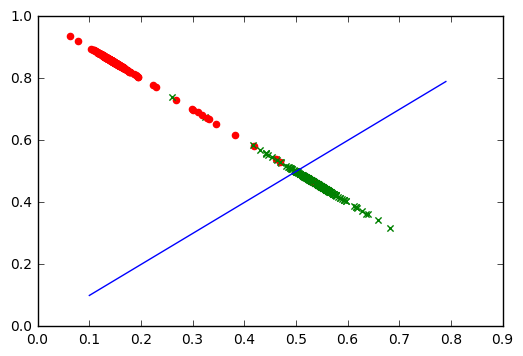

In [66]:

for index in range(len(y_valid)):
    if y_valid[index,1]==1:
        marker = 'o'
        color = 'r'
        label = '1'
    else:
        marker = 'x'
        color = 'g'
        label = '0'
    s=20
    plt.scatter(pro[index,0],pro[index,1],marker=marker,color=color,s = s,label=label)
    
a = np.array(range(10,80),dtype=float)/100
plt.plot(a,a,color='b')

In [62]:
[0:0.01:1]

SyntaxError: invalid syntax (<ipython-input-62-6ecb6ccfc9d4>, line 1)

In [44]:
from sklearn.metrics import roc_curve

In [46]:
fpr, tpr, thresholds = roc_curve(y_valid[:,1], pro[:,1], pos_label=1)

(-0.057346698850805754,
 1.0573466988508056,
 -0.057789279045439408,
 1.0608662021223625)

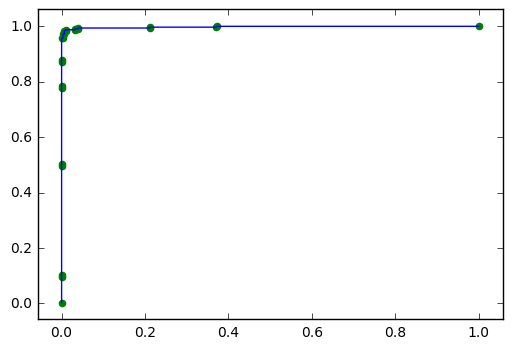

In [57]:
plt.plot(fpr,tpr)
plt.scatter(fpr,tpr,color ='g')
plt.axis('tight')